# Estimating dissimilarities

This tutorial shows how to estimate Representational Dissimilarity Matricies (RDMs) from data.

In [1]:
# relevant imports
import numpy as np
import os
from scipy import io
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
from nilearn.masking import compute_epi_mask
from nilearn.image import mean_img, resample_to_img 
from nilearn import plotting, masking
from nilearn.image import math_img
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.image import math_img, load_img
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
from nilearn.surface import load_surf_mesh
from nilearn import datasets
from rsatoolbox import vis
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

# Extracting lower triangles and between & within gestures rsa values

def extract_lower_triangle_no_diag(cov_3d):
    """
    Extracts the unique values of the lower triangle (excluding diagonal) of 
    2D covariance matrices stacked along the third dimension in a 3D array.

    Parameters:
        cov_3d (numpy.ndarray): A 3D array of shape (m, n, n), where each 
        slice cov_3d[i, :, :] is a 2D covariance matrix.

    Returns:
        numpy.ndarray: A 2D array of shape (m, k), where k = n * (n - 1) // 2,
        containing the unique lower-triangle values of the input 2D matrices,
        excluding the diagonal.
    """
    m, n, p = cov_3d.shape
    assert n == p, "Each 2D subarray should be a square matrix"
    
    # k is the number of unique values in the lower triangle excluding diagonal of nxn matrix
    k = n * (n - 1) // 2
    lower_triangle_values = np.zeros((m, k))
    
    for i in range(m):
        # Extract the lower triangle excluding the diagonal
        lower_triangle_values[i, :] = cov_3d[i, :, :][np.tril_indices(n, k=-1)]
    
    return lower_triangle_values

save_path = "/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/figures"  # Change this to your desired path

# Get today's date and convert it to a string in the format YYYYMMDD
today_str = datetime.today().strftime('%Y%m%d')


In [2]:
ds_path = '/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)

layout.add_derivatives(os.path.join(ds_path, "results", "first-level"))


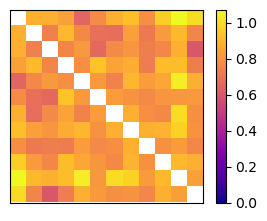

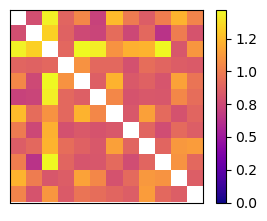

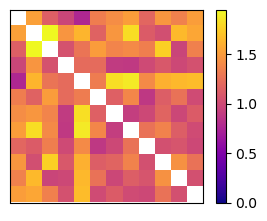

In [3]:
# List of subject IDs
sID = ['01', '02', '04']

# List of run IDs
runs = ['01', '02', '03', '04', '05']

# List of contrasts
contrast_list = np.array(['L1', 'N1', 'Ac1', 'Ab1', 'L2', 'N2', 'Ac2', 'Ab2', 'L3', 'N3', 'Ac3', 'Ab3'])

# Define the mask
mask = 'ba45'

# Loop through each subject
for si in sID: 

    my_counter = 0

    # Initialize the DataFrame to store the data
    data = pd.DataFrame()

    # Define mask path based on the mask type
    if mask == 's1':
        mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{si}/sub-{si}_transformed_joern_handmask.nii.gz'
    elif mask == 'ba45':
        mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{si}/sub-{si}_transformed_ba45_harvard_handmask.nii.gz'
    else:
        print("Invalid mask type. Skipping.")
        continue

    # Check if mask file exists
    if not os.path.exists(mask_path):
        print(f"Mask not found: {mask_path}")
        continue

    # Load the mask
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata()
    
    # If the mask is of type 's1', apply additional processing
    if mask == 's1':
        mask_id = 1
        mask_data[(mask_data > mask_id) | (mask_data < mask_id)] = 0
        mask_data[mask_data == mask_id] = 1 
        mask_img_mod = nib.Nifti1Image(mask_data, affine = mask_img.affine, header= mask_img.header)
    else:
        mask_img_mod = mask_img
    
    # Loop through each run
    for run in runs:

        # Loop through each contrast
        for contrast in contrast_list:
            
            filenames = layout.get(subject=si, run=run, desc=contrast, suffix='size', extension='.nii.gz', return_type='filename')
                            
            #print(filenames)
            
            # Ensure at least one filename is returned before proceeding
            if not filenames:
                print(f"No filenames found for contrast {contrast}. Skipping.")
                continue
            
            # Load the statistical image
            stat_img = nib.load(filenames[0])
            
            # Resample the mask to match the statistical image's dimensions
            resampled_mask_img = resample_to_img(mask_img_mod, stat_img, interpolation='nearest')
            
            # Apply the mask to the statistical image
            masked_data = masking.apply_mask(stat_img, resampled_mask_img)
            nVox = masked_data.size
            
            # Store the masked data in the DataFrame
            if data.empty:
                data = pd.DataFrame(np.nan, index=np.arange(len(contrast_list) * len(runs)), columns=np.arange(nVox))
            
            data.iloc[my_counter, :] = masked_data
            my_counter = my_counter + 1
  
    # Prepare descriptors for RSA
    des = {'session': 1, 'subj': int(si)}
    obs_des = {'conds': np.tile(['cond_%02d' % x for x in range(1, len(contrast_list)+1)], len(runs)), 'run': np.repeat(runs, len(contrast_list))}
    chn_des = {'voxels': ['voxel_%d' % x for x in range(nVox)]}
    
    # Create the RSA dataset
    my_rsd_data = rsatoolbox.data.Dataset(measurements=data.values, descriptors=des, obs_descriptors=obs_des, channel_descriptors=chn_des)
    
    # Calculate noise precision and RDM
    noise_prec_eye = rsatoolbox.data.noise.prec_from_measurements(my_rsd_data, obs_desc='conds', method='shrinkage_eye')
    rdm_cv_eye = rsatoolbox.rdm.calc_rdm(my_rsd_data, descriptor='conds', method='crossnobis', noise=noise_prec_eye, cv_descriptor='run')
    my_rdm = rdm_cv_eye
    
    # Extract and save the RSA matrix
    my_rsa_matrix = my_rdm.get_matrices()
    filename_matrix = f"{save_path}/my_rsa_matrix_subj{si}_{mask}_{today_str}.npy"
    np.save(filename_matrix, my_rsa_matrix)

    # Visualize and save the RDM
    rsatoolbox.vis.show_rdm(my_rdm, vmin=0, n_row=1, figsize=(3.5,2.5), cmap='plasma')
    ax = plt.gca()
    im = ax.get_images()[0]
    cbar_obj = plt.colorbar(im)
    cbar_obj.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    filename = f"{save_path}/my_rdm_{mask}_subj{si}_{today_str}.jpeg"
    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()


In [4]:
dfs = []  # list to hold the individual DataFrames

for m, si in enumerate(sID): 
    
    filename = f"{save_path}/my_rsa_matrix_subj{si}_{mask}_{today_str}.npy"
    my_rsa_matrix = np.load(filename)
    
    lower_triangles = extract_lower_triangle_no_diag(my_rsa_matrix)
    
    # Create a sample data frame
    data = {'SN': [si] * 66, 
            'values': np.array(lower_triangles).ravel(),
            'gesture_row': ['p'] * 6 + ['f'] * 22 + ['v'] * 38, 
            'gesture_col': ['p'] * 6 + 
          ['p'] * 4 + 
          ['p'] * 4 + ['f'] * 1 + 
          ['p'] * 4 + ['f'] * 2 + 
          ['p'] * 4 + ['f'] * 3 + 
          ['p'] * 4 + ['f'] * 4 + 
          ['p'] * 4 + ['f'] * 4 + ['v'] * 1 +
          ['p'] * 4 + ['f'] * 4 + ['v'] * 2 + 
          ['p'] * 4 + ['f'] * 4 + ['v'] * 3, 
            'semantic_row': ['n'] * 1 + ['x'] * 2 + ['a'] * 3 + 
           ['l'] * 4 + 
           ['n'] * 5 + 
           ['x'] * 6 + 
           ['a'] * 7 + 
           ['l'] * 8 + 
           ['n'] * 9 +
           ['x'] * 10 + 
           ['a'] * 11, 
            'semantic_col': 
           ['l'] + 
           ['l'] + ['n'] + 
           ['l'] + ['n'] + ['x'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] +
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] +
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x'] + ['a'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + 
           ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x'] + ['a'] + ['l'] + ['n'] + ['x']}
    
    dfs.append(pd.DataFrame(data))

# concatenate all the individual DataFrames into one large DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df['within_gesture'] = final_df['gesture_row'] == final_df['gesture_col']
final_df['gesture_condition'] = final_df['gesture_row'] + '-' + final_df['gesture_col'] 
final_df['semantic_condition'] = final_df['semantic_row'] + '-' + final_df['semantic_col'] 

# Creating a dictionary to map the conditions that should be combined
condition_mapping = {
    'a-l': 'a-l', 'l-a': 'a-l',
    'a-n': 'a-n', 'n-a': 'a-n',
    'x-l': 'x-l', 'l-x': 'x-l',
    'x-a': 'x-a', 'a-x': 'x-a',
    'n-x': 'x-n', 'x-n': 'x-n',
    'l-n': 'l-n', 'n-l': 'l-n',
    'a-a': 'a-a', 'x-x': 'x-x', 
    'n-n': 'n-n', 'l-l': 'l-l'}

# Using map function to create a new column with combined conditions
final_df['semantic_condition'] = final_df['semantic_condition'].map(condition_mapping)
final_df['l_present'] = (final_df['semantic_row'] == 'l') | (final_df['semantic_col'] == 'l')
final_df['x_present'] = (final_df['semantic_row'] == 'x') | (final_df['semantic_col'] == 'x')
final_df['a_present'] = (final_df['semantic_row'] == 'a') | (final_df['semantic_col'] == 'a')
final_df['n_present'] = (final_df['semantic_row'] == 'n') | (final_df['semantic_col'] == 'n')
final_df['same_semantic'] = final_df['semantic_row'] == final_df['semantic_col']

In [5]:
import pandas as pd
import numpy as np  # Make sure NumPy is imported

# Assume final_df is predefined...

unique_SN = final_df['SN'].unique()
data_to_append = []  # Initialize a list to store the data

# Loop through each SN
for sn in unique_SN:
    print(f"Processing SN: {sn}")  # Debugging line
    
    # Get the vectors for each condition
    pp_values = final_df[(final_df['within_gesture'] == True) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'p-p')]['values']
    vv_values = final_df[(final_df['within_gesture'] == True) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'v-v')]['values']
    ff_values = final_df[(final_df['within_gesture'] == True) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'f-f')]['values']
    
    pf_values = final_df[(final_df['within_gesture'] == False) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'f-p')]['values']
    pv_values = final_df[(final_df['within_gesture'] == False) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'v-p')]['values']
    fv_values = final_df[(final_df['within_gesture'] == False) & (final_df['SN'] == sn) & (final_df['gesture_condition'] == 'v-f')]['values']
    
    # Calculate correlations
    corr_pp_vv = np.corrcoef(pp_values, vv_values)[0, 1]
    corr_pp_ff = np.corrcoef(pp_values, ff_values)[0, 1]
    corr_vv_ff = np.corrcoef(vv_values, ff_values)[0, 1]
    
    corr_pf_pv = np.corrcoef(pf_values, pv_values)[0, 1]
    corr_pv_fv = np.corrcoef(pv_values, fv_values)[0, 1]
    corr_pf_fv = np.corrcoef(pf_values, fv_values)[0, 1]
    
    data_to_append.append({
        'SN': sn,
        'corr_pp_vv': corr_pp_vv,
        'corr_pp_ff': corr_pp_ff,
        'corr_vv_ff': corr_vv_ff,
        'corr_pf_pv': corr_pf_pv,
        'corr_pv_fv': corr_pv_fv,
        'corr_pf_fv': corr_pf_fv,
    })

pd.DataFrame( data_to_append )

Processing SN: 01
Processing SN: 02
Processing SN: 04


,SN,corr_pp_vv,corr_pp_ff,corr_vv_ff,corr_pf_pv,corr_pv_fv,corr_pf_fv
0,01,-0.343555,-0.504495,-0.354821,0.302983,0.710230,0.409176
1,02,0.670376,0.948250,0.617929,0.792258,0.555389,0.564470
2,04,0.866583,-0.426063,-0.377984,0.589434,0.305777,-0.067044


In [6]:
from scipy.stats import ttest_1samp
import pandas as pd  # Make sure to import pandas

unique_SN = final_df['SN'].unique()
ttest_data_to_append = []  # Initialize a list to store the data

for sn in unique_SN: 
    # Conducting a one-sample t-test for `within_gesture`
    t_stat_within, p_val_within = ttest_1samp(
        final_df[(final_df['within_gesture'] == True) & (final_df['SN'] == sn)]['values'], 
        popmean=0
    )
    
    # Conducting a one-sample t-test for `between_gesture`
    t_stat_between, p_val_between = ttest_1samp(
        final_df[(final_df['within_gesture'] == False) & (final_df['SN'] == sn)]['values'], 
        popmean=0
    )

    ttest_data_to_append.append({
        'SN': sn,
        't_stat_within': t_stat_within,
        'p_val_within': p_val_within,
        't_stat_between': t_stat_between,
        'p_val_between': p_val_between
    })

# Creating DataFrame from the appended data
ttest_results_df = pd.DataFrame(ttest_data_to_append)

# Check the resulting DataFrame
ttest_results_df


,SN,t_stat_within,p_val_within,t_stat_between,p_val_between
0,01,61.678199,1.955763e-21,55.577505,1.572703e-44
1,02,21.404185,9.845525e-14,34.107345,8.280284e-35
2,04,16.928603,4.477369e-12,33.727360,1.373830e-34


/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2660864462.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['SN', 'gesture_condition'])
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2660864462.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


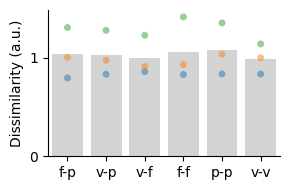

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume final_df is predefined...
custom_order = ['f-p', 'v-p', 'v-f', 'f-f', 'p-p', 'v-v']

# Define your custom order here, if needed
filtered_data = final_df[final_df['gesture_condition'].isin(custom_order)]
filtered_data['gesture_condition'] = pd.Categorical(filtered_data['gesture_condition'], categories=custom_order, ordered=True)

# Sorting, resetting index, grouping by 'SN' and 'semantic_condition', and calculating the mean
filtered_data_mean = (
    filtered_data
    .groupby(['SN', 'gesture_condition'])
    .agg({'values': 'mean'})  # Explicitly define which columns to aggregate
    .reset_index()  # to move 'SN' and 'semantic_condition' back to columns
)

# Creating a bar graph using catplot
g = sns.catplot(
    data=filtered_data_mean, 
    x='gesture_condition', y='values',
    kind='bar',
    color='lightgrey',
    errorbar=None, height=2, aspect=1.5,
    legend=False  # remove the legend
)

# Adding individual data points using stripplot
sns.stripplot(
    data=filtered_data_mean,
    x='gesture_condition', y='values',
    hue = 'SN',
    jitter=False,  # add some jitter for better visualization
    alpha= 0.5,  # make points semi-transparent to see overlapping points
    ax=g.axes[0,0],  # plot on the same axis
    legend=False,
    dodge=False,  # to align points with bars
)


# Set y-axis to show only integer ticks
g.axes[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
# Additional plot formatting (optional)
g.set_axis_labels('', 'Dissimilarity (a.u.)')
g.despine(top=True, right=True)

filename = f"{save_path}/my_within_between_gestures_{mask}_{today_str}.jpeg"
plt.savefig(filename, format='jpeg', dpi=300)
    
plt.tight_layout()
plt.show()


/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2323252853.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['semantic_condition'] = pd.Categorical(filtered_data['semantic_condition'], categories=custom_order, ordered=True)
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2323252853.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['SN', 'semantic_condition'])
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has c

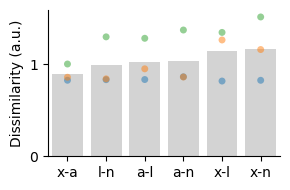

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter data
filtered_data = final_df[final_df['within_gesture'] == True]

# Assume that 'condition' is a column in 'sub_df'; sort by this column if desired
custom_order = ['x-a',
                'l-n',
                'a-l',
                'a-n',
                'x-l',
                'x-n',]

# Define your custom order here, if needed
filtered_data['semantic_condition'] = pd.Categorical(filtered_data['semantic_condition'], categories=custom_order, ordered=True)

# Sorting, resetting index, grouping by 'SN' and 'semantic_condition', and calculating the mean
filtered_data_mean = (
    filtered_data
    .sort_values(by=['SN', 'semantic_condition'])
    .groupby(['SN', 'semantic_condition'])
    .agg({'values': 'mean'})  # Explicitly define which columns to aggregate
    .reset_index()  # to move 'SN' and 'semantic_condition' back to columns
)

g = sns.catplot(
    data=filtered_data_mean, 
    x='semantic_condition', y='values', 
    kind='bar',
    color='lightgrey',
    errorbar=None, height=2, aspect=1.5,
    legend=False  
)

# Adding individual data points using stripplot
sns.stripplot(
    data=filtered_data_mean,
    x='semantic_condition', y='values',
    hue = 'SN',
    jitter=False,  # add some jitter for better visualization
    alpha= 0.5,  # make points semi-transparent to see overlapping points
    ax=g.axes[0,0],  # plot on the same axis
    legend=False,
    dodge=False,  # to align points with bars
)



# Set y-axis to show only integer ticks
g.axes[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
# Additional plot formatting (optional)
g.set_axis_labels('', 'Dissimilarity (a.u.)')
g.despine(top=True, right=True)

filename = f"{save_path}/my_within_gestures_similarity_{mask}_{today_str}.jpeg"
plt.savefig(filename, format='jpeg', dpi=300)

# Adjust the layout
plt.tight_layout()
plt.show()
    

/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2850030826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['semantic_condition'] = pd.Categorical(filtered_data['semantic_condition'], categories=custom_order, ordered=True)
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_91848/2850030826.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['SN', 'semantic_condition'])
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has c

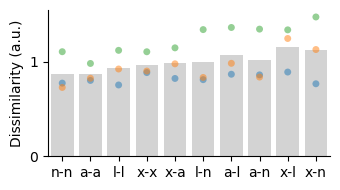

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

filtered_data = final_df[final_df['within_gesture'] == False]

# Your custom order
custom_order = ['n-n','a-a', 'l-l','x-x',  'x-a', 'l-n', 'a-l', 'a-n','x-l', 'x-n']
# Define your custom order here, if needed
filtered_data['semantic_condition'] = pd.Categorical(filtered_data['semantic_condition'], categories=custom_order, ordered=True)

# Sorting, resetting index, grouping by 'SN' and 'semantic_condition', and calculating the mean
filtered_data_mean = (
    filtered_data
    .sort_values(by=['SN', 'semantic_condition'])
    .groupby(['SN', 'semantic_condition'])
    .agg({'values': 'mean'})  # Explicitly define which columns to aggregate
    .reset_index()  # to move 'SN' and 'semantic_condition' back to columns
)

g = sns.catplot(
    data=filtered_data_mean, 
    x='semantic_condition', y='values',
    kind='bar',
    color='lightgrey',
    errorbar=None, height=2, aspect=1.75,
    legend=False  
)


    # Adding individual data points using stripplot
sns.stripplot(
    data=filtered_data_mean,
    x='semantic_condition', y='values',
    hue = 'SN',
    jitter=False,  # add some jitter for better visualization
    alpha= 0.5,  # make points semi-transparent to see overlapping points
    ax=g.axes[0,0],  # plot on the same axis
    legend=False,
    dodge=False,  # to align points with bars
)


# Set y-axis to show only integer ticks
g.axes[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
# Additional plot formatting (optional)
g.set_axis_labels('', 'Dissimilarity (a.u.)')
g.despine(top=True, right=True)

filename = f"{save_path}/my_between_gestures_similarity_{mask}_{today_str}.jpeg"
plt.savefig(filename, format='jpeg', dpi=300)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


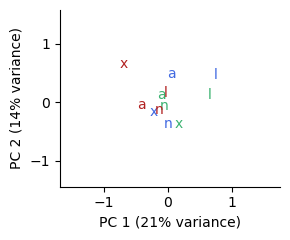

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


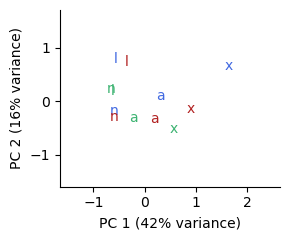

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


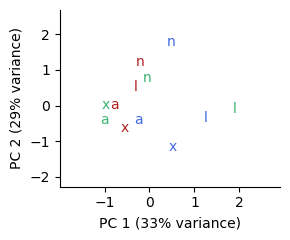

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assume sID and save_path are predefined
# sID = ["01", "02", "03", "04"]

for m, si in enumerate(sID):
    
    filename = f"{save_path}/my_rsa_matrix_subj{si}_{mask}_{today_str}.npy"
    my_rsa_matrix = np.load(filename)
    
    # Perform PCA and reduce to 2 components
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(my_rsa_matrix[0])

    # Extracting the explained variance ratio
    explained_var = pca.explained_variance_ratio_ * 100

    # Labels for each point with an index to ensure uniqueness
    labels = ["l", "n", "x", "a", "l", "n", "x", "a", "l", "n", "x", "a"]
    conditions = ["Palm"] * 4 + ["Fist"] * 4 + ["Peace"] * 4
    
    # Create a colormap with three distinct colors
    condition_colors = {'Palm': 'royalblue', 'Fist': 'mediumseagreen', 'Peace': 'firebrick'}
    
    # Use seaborn-deep style
    plt.style.use('seaborn-v0_8-deep')
    
    # Create a smaller plot
    fig, ax = plt.subplots(figsize=(3, 2.5))

    # Annotate each point
    for i, label in enumerate(labels):
        plt.annotate(label, 
                     (data_pca[i, 0], data_pca[i, 1]), 
                     textcoords="offset points", 
                     xytext=(0, 0), 
                     ha='center', 
                     fontsize=10, 
                     color=condition_colors[conditions[i]])
    
    # Expand the range of x and y axes if needed
    plt.xlim(data_pca[:,0].min() - 1, data_pca[:,0].max() + 1)
    plt.ylim(data_pca[:,1].min() - 1, data_pca[:,1].max() + 1)

    # Including the explained variance in the axis labels
    plt.xlabel(f'PC 1 ({explained_var[0]:.0f}% variance)')
    plt.ylabel(f'PC 2 ({explained_var[1]:.0f}% variance)')

    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Removing top and right-hand frames
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remove the legend and gridlines
    plt.legend().set_visible(False)
    plt.grid(False)
    
    # Adjust the layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot
    filename = f"{save_path}/my_pca_{mask}_subj{si}.jpeg"
    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()


In [11]:
# partial correlation:
import pingouin as pg

dfs = []  # list to hold the individual DataFrames
mask_list = ['S1hand', 'Broca', 'V1']

for m, si in enumerate(sID): 
    
        
    s1_mask = f"{save_path}/my_rsa_matrix_subj{si}_S1hand_{today_str}.npy"
    b_mask = f"{save_path}/my_rsa_matrix_subj{si}_Broca_{today_str}.npy"
    v1_mask = f"{save_path}/my_rsa_matrix_subj{si}_V1_{today_str}.npy"
    vent_mask = f"{save_path}/my_rsa_matrix_subj{si}_Ventrical_{today_str}.npy"
    
    s1_rsa_matrix = np.load(s1_mask)
    b_rsa_matrix = np.load(b_mask)
    v1_rsa_matrix = np.load(v1_mask)
    vent_rsa_matrix = np.load(vent_mask)
    
    s1_lower_triangles = extract_lower_triangle_no_diag(s1_rsa_matrix)
    b_lower_triangles = extract_lower_triangle_no_diag(b_rsa_matrix)
    v1_lower_triangles = extract_lower_triangle_no_diag(v1_rsa_matrix)
    vent_lower_triangles = extract_lower_triangle_no_diag(vent_rsa_matrix)
    
    # Create a sample data frame
    data = {'SN': [si] * len(np.array(s1_lower_triangles).ravel()), 
            'S1hand': np.array(s1_lower_triangles).ravel(),
            'B': np.array(b_lower_triangles).ravel(), 
            'V1': np.array(v1_lower_triangles).ravel(),
            'vent': np.array(vent_lower_triangles).ravel()}
    
        
    dfs.append(pd.DataFrame(data))
        
mask_df = pd.concat(dfs, ignore_index=True)    

mask_df.head()

print( pg.partial_corr(data=mask_df[mask_df['SN'] == '01'], x='B', y='S1hand').round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '02'], x='B', y='S1hand').round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '04'], x='B', y='S1hand').round(3))

print( pg.partial_corr(data=mask_df[mask_df['SN'] == '01'], x='B', y='S1hand', covar='V1').round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '02'], x='B', y='S1hand', covar='V1').round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '04'], x='B', y='S1hand', covar='V1').round(3))

print( pg.partial_corr(data=mask_df[mask_df['SN'] == '01'], x='B', y='S1hand', covar=['V1', 'vent']).round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '02'], x='B', y='S1hand', covar=['V1', 'vent']).round(3))
print( pg.partial_corr(data=mask_df[mask_df['SN'] == '04'], x='B', y='S1hand', covar=['V1', 'vent']).round(3))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/figures/my_rsa_matrix_subj01_S1hand_20231029.npy'